In [1]:
import wandb
import torch
import vit

api = wandb.Api()
runs = api.runs("hpoeche-team/vit-classifier")
for run in runs:
    print(run.id, run.name)

ModuleNotFoundError: No module named 'cv2'

In [11]:
run = api.run("hpoeche-team/vit-classifier/3hz7a8y5")
model_config = run.config['model']
artifact_dir: str = run.logged_artifacts()[0].download()
artifact_dir = artifact_dir #.replace(':', '-')
artifact_dir

wandb: Downloading large artifact cifar10or100:v85, 72.57MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


'/home/poeche/ws/ba/code/artifacts/cifar10or100:v85'

In [12]:
model = vit.get_model(model_config)
model.load_state_dict(torch.load(artifact_dir + '/cifar10.pt', map_location='cpu'))

/tmp/ipykernel_1910524/2409851203.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(artifact_dir + '/cifar10.pt', map_location='cpu'))


<All keys matched successfully>

In [13]:
import dataset_utils as datasets
cifar_conf: datasets.DatasetConfig = {
    'dataset': 'CIFAR100',
    'augmentation': None,
    'batch_size': 512,
    'num_workers': 1
}
_, test_cifar = datasets.get_dataloader(cifar_conf, 'data')

Files already downloaded and verified
Files already downloaded and verified


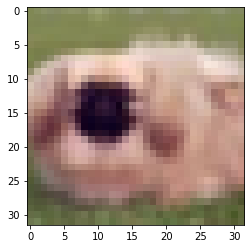

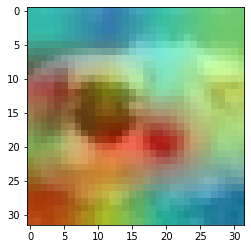

In [41]:
import random
import matplotlib.pyplot as plt

image = next(iter(test_cifar))[0][random.randint(0, 127)]
v = image.permute(1, 2, 0).numpy()
v -= v.min()
v /= v.max()

plt.imshow(v)
plt.show()
attention_tracker = vit.VitAttentionExtractor(model)
model.eval()
model(vit.image_to_patches(image.unsqueeze(0), 8))

att = attention_tracker.attention_rollout(head_combination='max', ignore_ratio=0.2)
_ = vit.show_image_attention(image, att, interpolate=True)

In [22]:
device = torch.device('cuda:1')

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

model.to(device)
model.eval()
top1 = 0
top5 = 0
for img, label in test_cifar:
    img = img.to(device)
    label = label.to(device)
    accs = accuracy(model(img), label, (1, 5))
    top1 += accs[0].item()
    top5 += accs[1].item()
    
top1 / len(test_cifar), top5 / len(test_cifar)

(64.1796875, 85.59742622375488)

In [ ]:
imagenet_conf: datasets.DatasetConfig = {
    'dataset': 'IMAGENET',
    'augmentation': None,
    'batch_size': 128,
    'num_workers': 1
}
_, test_imnet = datasets.get_dataloader(cifar_conf, 'data')

In [25]:
import vit_inspection
positions = torch.arange(65)

patch_embed = model.pos_embedding.squeeze().detach()[1:, ]
patch_embed.shape

torch.Size([196, 384])

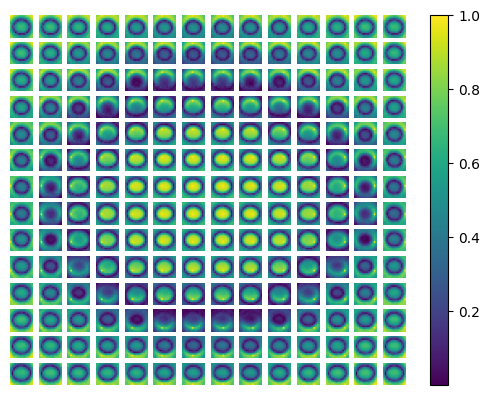

In [26]:
vit_inspection.plot_pos_embed(patch_embed, 14)